# CS 412 Project

# 1. Data Exploration

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import analysis

In [139]:
conditions = pd.read_csv("data/conditions.csv")
patients = pd.read_csv("data/patients.csv")
observations = pd.read_csv("data/observations.csv")
care_plans = pd.read_csv("data/careplans.csv")
encounters = pd.read_csv("data/encounters.csv")
devices = pd.read_csv("data/devices.csv")
supplies = pd.read_csv('data/supplies.csv')
procedures = pd.read_csv("data/procedures.csv")
medications = pd.read_csv("data/medications.csv")

### IDs of patients that have been diagnosed with COVID-19

In [356]:
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

### IDs for all patients that died in the simulation

In [357]:
deceased_patients = patients[patients.DEATHDATE.notna()].Id

### IDs for patients with admission due to COVID-19

In [358]:
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT

###  IDs for patients that have completed the care plan for isolation at home

In [359]:
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

### every patient with a negative SARS-CoV-2 test

In [360]:
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()

### Survivors(the union of those who have completed isolation at home or have a negative SARS-CoV-2 test)

In [361]:
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)

### COVID-19 conditions out of all conditions in the simulation

In [362]:
covid_conditions = conditions[conditions.CODE == 840539006]

### new DataFrame with boolean columns representing various outcomes, like admit, recovery or death

In [363]:
cp = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')
isolation_ids = care_plans[(care_plans.CODE == 736376001) & (care_plans.REASONCODE == 840539006)].PATIENT
cp['isolation'] = cp.Id.isin(isolation_ids)
cp['admit'] = cp.Id.isin(inpatient_ids)
cp['recovered'] = cp.Id.isin(survivor_ids)
cp['death'] = cp.DEATHDATE.notna()
icu_ids = encounters[encounters.CODE == 305351004].PATIENT
cp['icu_admit'] = cp.Id.isin(icu_ids)
vent_ids = procedures[procedures.CODE == 26763009].PATIENT
cp['ventilated'] = cp.Id.isin(vent_ids)

In [364]:
covid_info = cp[['PATIENT', 'recovered', 'death', 'START', 'DEATHDATE', 'BIRTHDATE', 'GENDER', 'admit', 'icu_admit']]

In [365]:
covid_info = covid_info.rename(columns={'START': 'covid_start'})

In [366]:
covid_related_conditions = conditions[pd.to_datetime(conditions.START) > pd.to_datetime('2020-01-20')]

### all conditions for COVID-19 patients

In [367]:
covid_patient_conditions = covid_info.merge(covid_related_conditions, on='PATIENT')

# 2. Preparing Data for Machine Learning

In [368]:
X = patients[patients['Id'].isin(covid_patient_ids)]

In [369]:
X = X[["Id","BIRTHDATE", "DEATHDATE", "RACE", "GENDER"]]

In [370]:
X

,Id,BIRTHDATE,DEATHDATE,RACE,GENDER
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,2017-08-24,NaN,white,M
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,2016-08-01,NaN,white,F
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,2004-01-09,NaN,white,F
3,cc3c806f-4a09-4a89-a990-4286450956be,1996-11-15,NaN,white,M
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,2019-06-12,NaN,white,F
...,...,...,...,...,...
124140,12d4e7cc-e86b-46c5-a696-ecd52b929b71,1948-06-03,NaN,white,M
124141,2dbac353-17bb-42da-9aa0-a302f052d1a3,1941-10-07,NaN,white,F
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,1944-09-15,NaN,white,M
124147,503d768f-481c-46e2-bcdb-a6116686351a,1934-12-26,2020-03-18,white,M


#### Calculate AGE

In [371]:
def calculate_age(row):
    birthdate = row['BIRTHDATE']
    deathdate = row['DEATHDATE']
    # Use November 1st, 2020 as the reference date if DEATHDATE is NaN
    reference_date = pd.to_datetime('2020-11-01')
    if pd.isna(deathdate):
        age = reference_date.year - birthdate.year - ((reference_date.month, reference_date.day) < (birthdate.month, birthdate.day))
    else:
        age = deathdate.year - birthdate.year - ((deathdate.month, deathdate.day) < (birthdate.month, birthdate.day))
    return age

In [372]:
X['BIRTHDATE'] = pd.to_datetime(X['BIRTHDATE'])
X['DEATHDATE'] = pd.to_datetime(X['DEATHDATE'])

In [373]:
X['AGE'] = X.apply(calculate_age, axis=1)

In [374]:
X = X[["Id","AGE","RACE","GENDER"]]

In [375]:
X

,Id,AGE,RACE,GENDER
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,3,white,M
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,4,white,F
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,16,white,F
3,cc3c806f-4a09-4a89-a990-4286450956be,23,white,M
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1,white,F
...,...,...,...,...
124140,12d4e7cc-e86b-46c5-a696-ecd52b929b71,72,white,M
124141,2dbac353-17bb-42da-9aa0-a302f052d1a3,79,white,F
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,76,white,M
124147,503d768f-481c-46e2-bcdb-a6116686351a,85,white,M


In [376]:
# Summary statistics for numeric columns
numeric_summary = X.describe()

# Summary statistics for categorical columns
# Summary statistics for RACE
RACE_summary = X['RACE'].value_counts().reset_index()
RACE_summary.columns = ['RACE', 'Counts']

# Summary statistics for GENDER
GENDER_summary = X['GENDER'].value_counts().reset_index()
GENDER_summary.columns = ['GENDER', 'Counts']

# Display the results
print("Summary Statistics for AGE:")
print(numeric_summary)

print("\nSummary Statistics for RACE:")
print(RACE_summary)

print("\nSummary Statistics for GENDER:")
print(GENDER_summary)

Summary Statistics for AGE:
                AGE
count  88166.000000
mean      41.410453
std       23.676283
min        0.000000
25%       22.000000
50%       41.000000
75%       59.000000
max      111.000000

Summary Statistics for RACE:
     RACE  Counts
0   white   74065
1   black    7425
2   asian    6165
3  native     412
4   other      99

Summary Statistics for GENDER:
  GENDER  Counts
0      F   45205
1      M   42961


#### One-hot encoding for RACE, GENDER, AGE

In [377]:
X = pd.get_dummies(X, columns=['RACE'])

In [378]:
X = pd.get_dummies(X, columns=['GENDER'])

In [379]:
# Create Bins
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ['under 20', '20 to 40', '40 to 60', '60 to 80', 'over 80']

# Cut the 'Age' column into bins
X['Age_Category'] = pd.cut(X['AGE'], bins=bins, labels=labels, right=False)

# Use get_dummies to create binary columns
age_dummies = pd.get_dummies(X['Age_Category'], prefix='Age')

# Concatenate the binary columns to the original DataFrame
X = pd.concat([X, age_dummies], axis=1)

df = Age_Categories
Age_Categories['AGE'] = X['Age_Category']


In [380]:
# Drop the original 'Age' and 'Age_Category' columns if needed
X = X.drop(['AGE', 'Age_Category'], axis=1)

In [381]:
X

,Id,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,GENDER_F,GENDER_M,Age_under 20,Age_20 to 40,Age_40 to 60,Age_60 to 80,Age_over 80
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,0,0,0,0,1,0,1,1,0,0,0,0
1,9bcf6ed5-d808-44af-98a0-7d78a29ede72,0,0,0,0,1,1,0,1,0,0,0,0
2,5163c501-353c-4a82-b863-a3f1df2d6cf1,0,0,0,0,1,1,0,1,0,0,0,0
3,cc3c806f-4a09-4a89-a990-4286450956be,0,0,0,0,1,0,1,0,1,0,0,0
4,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,0,0,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124140,12d4e7cc-e86b-46c5-a696-ecd52b929b71,0,0,0,0,1,0,1,0,0,0,1,0
124141,2dbac353-17bb-42da-9aa0-a302f052d1a3,0,0,0,0,1,1,0,0,0,0,1,0
124146,8cf835a7-f161-4fe9-a559-350c97a3450e,0,0,0,0,1,0,1,0,0,0,1,0
124147,503d768f-481c-46e2-bcdb-a6116686351a,0,0,0,0,1,0,1,0,0,0,0,1


## Calculate Summary Statistics

In [382]:
Age_Categories

0                                                  under 20
1                                                  under 20
2                                                  under 20
3                                                  20 to 40
4                                                  under 20
                                ...                        
124141                                             60 to 80
124146                                             60 to 80
124147                                              over 80
124149                                              over 80
AGE       0         under 20
1         under 20
2       ...
Name: Age_Category, Length: 88167, dtype: object

In [383]:
# Summary statistics for AGE
AGE_summary = Age_Categories['AGE'].value_counts().reset_index()
AGE_summary.columns = ['Age Range', 'Counts']


# Display the results
print("Summary Statistics for AGE:")
print(numeric_summary)
print('\n')
print(AGE_summary)

print("\nSummary Statistics for RACE:")
print(RACE_summary)

print("\nSummary Statistics for GENDER:")
print(GENDER_summary)

Summary Statistics for AGE:
                AGE
count  88166.000000
mean      41.410453
std       23.676283
min        0.000000
25%       22.000000
50%       41.000000
75%       59.000000
max      111.000000


  Age Range  Counts
0  40 to 60   24433
1  20 to 40   23388
2  under 20   18992
3  60 to 80   16482
4   over 80    4871

Summary Statistics for RACE:
     RACE  Counts
0   white   74065
1   black    7425
2   asian    6165
3  native     412
4   other      99

Summary Statistics for GENDER:
  GENDER  Counts
0      F   45205
1      M   42961


#### SYMPTOMS

#### sample table about symptoms by patients

In [384]:
covid_patient_conditions_description = covid_patient_conditions[["PATIENT", "DESCRIPTION"]]

In [385]:
sample = covid_patient_conditions_description.pivot_table(index='PATIENT', columns='DESCRIPTION', aggfunc=len, fill_value=0)

In [386]:
sample

DESCRIPTION,Acquired coagulation disorder (disorder),Acute Cholecystitis,Acute allergic reaction,Acute bacterial sinusitis (disorder),Acute bronchitis (disorder),Acute deep venous thrombosis (disorder),Acute pulmonary embolism (disorder),Acute respiratory distress syndrome (disorder),Acute respiratory failure (disorder),Acute viral pharyngitis (disorder),...,Stroke,Suspected COVID-19,Suspected lung cancer (situation),Tear of meniscus of knee,Third degree burn,Tubal pregnancy,Viral sinusitis (disorder),Vomiting symptom (finding),Wheezing (finding),Whiplash injury to neck
PATIENT,,,,,,,,,,,,,,,,,,,,,
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
0001054e-77c4-4e09-8310-7e5b1a579d8a,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
00019dce-e502-4272-82d2-d1c280f74150,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
0002760d-9404-43cb-873f-26b0a59d3a55,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
00034773-ca66-4191-8f43-56a9c20f8abf,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd108b-0ae3-4894-88ee-1de037fea1d2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
fffde06d-4cf8-462a-9429-b3946224c517,1,0,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,1,0
ffff5261-51f3-437c-9f5e-8cf237b26637,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [387]:
columns_to_keep = [col for col in sample.columns if "finding" in col]
sample_filtered = sample[columns_to_keep]

In [388]:
sample_filtered

DESCRIPTION,Body mass index 30+ - obesity (finding),Body mass index 40+ - severely obese (finding),Chill (finding),Cough (finding),Diarrhea symptom (finding),Dyspnea (finding),Fatigue (finding),Fever (finding),Headache (finding),Hemoptysis (finding),...,Loss of taste (finding),Muscle pain (finding),Nasal congestion (finding),Nausea (finding),Passive conjunctival congestion (finding),Respiratory distress (finding),Sore throat symptom (finding),Sputum finding (finding),Vomiting symptom (finding),Wheezing (finding)
PATIENT,,,,,,,,,,,,,,,,,,,,,
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,1,1,0,...,1,0,0,0,0,1,0,0,0,1
0001054e-77c4-4e09-8310-7e5b1a579d8a,0,0,0,0,0,0,1,1,0,0,...,1,0,0,1,0,0,0,1,1,0
00019dce-e502-4272-82d2-d1c280f74150,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
0002760d-9404-43cb-873f-26b0a59d3a55,0,0,0,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
00034773-ca66-4191-8f43-56a9c20f8abf,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffd108b-0ae3-4894-88ee-1de037fea1d2,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,1,1,0,0
fffde06d-4cf8-462a-9429-b3946224c517,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
ffff5261-51f3-437c-9f5e-8cf237b26637,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [389]:
X.set_index('Id', inplace=True)

In [390]:
merged_df = X.merge(sample_filtered, left_index=True, right_index=True)

In [391]:
merged_df

,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,GENDER_F,GENDER_M,Age_under 20,Age_20 to 40,Age_40 to 60,...,Loss of taste (finding),Muscle pain (finding),Nasal congestion (finding),Nausea (finding),Passive conjunctival congestion (finding),Respiratory distress (finding),Sore throat symptom (finding),Sputum finding (finding),Vomiting symptom (finding),Wheezing (finding)
1ff7f10f-a204-4bb1-aa72-dd763fa99482,0,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9bcf6ed5-d808-44af-98a0-7d78a29ede72,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5163c501-353c-4a82-b863-a3f1df2d6cf1,0,0,0,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
cc3c806f-4a09-4a89-a990-4286450956be,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12d4e7cc-e86b-46c5-a696-ecd52b929b71,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,0,1,0,0,1,0
2dbac353-17bb-42da-9aa0-a302f052d1a3,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8cf835a7-f161-4fe9-a559-350c97a3450e,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
503d768f-481c-46e2-bcdb-a6116686351a,0,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,0,1,0,0


#### ICU admitted (TRUE = 1, FALSE = 0)

In [392]:
covid_patient_conditions.set_index('PATIENT', inplace=True)

In [393]:
covid_patient_conditions_ICU = covid_patient_conditions[["icu_admit"]]

In [394]:
X = merged_df.merge(covid_patient_conditions_ICU, left_index=True, right_index=True)

In [395]:
X

,RACE_asian,RACE_black,RACE_native,RACE_other,RACE_white,GENDER_F,GENDER_M,Age_under 20,Age_20 to 40,Age_40 to 60,...,Muscle pain (finding),Nasal congestion (finding),Nausea (finding),Passive conjunctival congestion (finding),Respiratory distress (finding),Sore throat symptom (finding),Sputum finding (finding),Vomiting symptom (finding),Wheezing (finding),icu_admit
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,False
0001049f-9248-47fe-b479-ea80eb51ce4a,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffffadc8-7106-4b51-b003-1307776e9790,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,False
ffffadc8-7106-4b51-b003-1307776e9790,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,False
ffffadc8-7106-4b51-b003-1307776e9790,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,False
ffffadc8-7106-4b51-b003-1307776e9790,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,False


In [396]:
X = X.groupby(X.index).first()

In [397]:
X.columns = [col.replace(' (finding)', '') if isinstance(col, str) else col for col in X.columns]

In [398]:
list(X.columns)

['RACE_asian',
 'RACE_black',
 'RACE_native',
 'RACE_other',
 'RACE_white',
 'GENDER_F',
 'GENDER_M',
 'Age_under 20',
 'Age_20 to 40',
 'Age_40 to 60',
 'Age_60 to 80',
 'Age_over 80',
 'Body mass index 30+ - obesity',
 'Body mass index 40+ - severely obese',
 'Chill',
 'Cough',
 'Diarrhea symptom',
 'Dyspnea',
 'Fatigue',
 'Fever',
 'Headache',
 'Hemoptysis',
 'Joint pain',
 'Loss of taste',
 'Muscle pain',
 'Nasal congestion',
 'Nausea',
 'Passive conjunctival congestion',
 'Respiratory distress',
 'Sore throat symptom',
 'Sputum finding',
 'Vomiting symptom',
 'Wheezing',
 'icu_admit']

#### DEATH

In [399]:
X["DEATH"] = X.index.isin(deceased_patients).astype(int)

In [400]:
data = X

## Summary Statistics

In [407]:
# Summary statistics for DEATH
DEATH_summary = X['DEATH'].value_counts().reset_index()
DEATH_summary.columns = ['DEATH', 'Counts']
 
print("\nSummary Statistics for DEATH:")    
print(DEATH_summary)

len(X)


Summary Statistics for DEATH:
   DEATH  Counts
0      0   84519
1      1    3641


88160

# 3. Supervised Learning

In [234]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [235]:
X = data.drop(['DEATH', 'icu_admit'], axis=1)
y = data['DEATH']

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [237]:
from sklearn.ensemble import RandomForestClassifier

# Example: Using a Random Forest Classifier
model = RandomForestClassifier(random_state=42)

In [238]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Model Accuracy: 0.9611501814882033


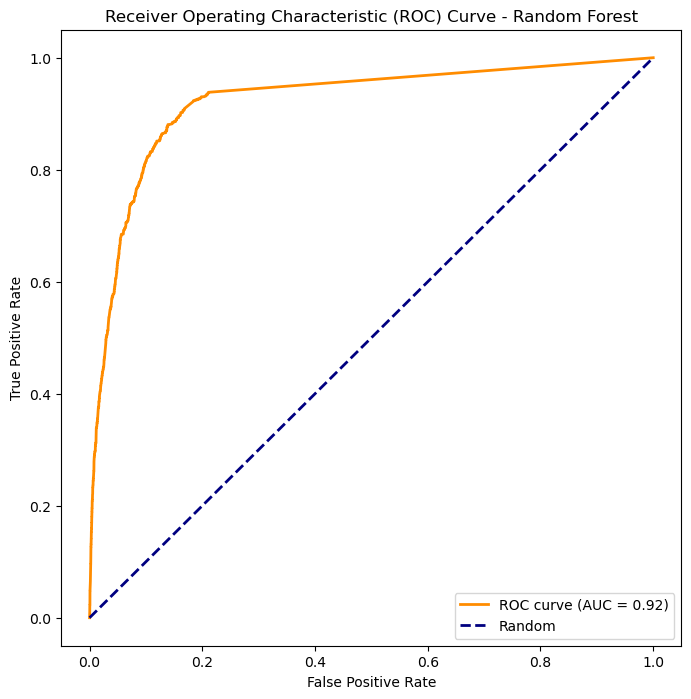

In [244]:
from sklearn.metrics import accuracy_score

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

# roc curve

# Compute ROC curve and AUC
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# 4. Model Evaluation

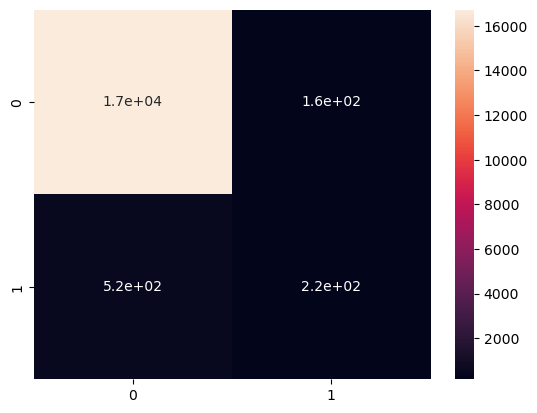

Mean Squared Error: 0.03884981851179673


In [247]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, accuracy_score, classification_report, precision_score, f1_score,recall_score

# For Classification
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

# For Regression
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [248]:
from sklearn.metrics import confusion_matrix
class_report = classification_report(y_test, y_pred)
print("Classification Report\n")
print(class_report)

Classification Report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16886
           1       0.58      0.30      0.39       746

    accuracy                           0.96     17632
   macro avg       0.77      0.64      0.69     17632
weighted avg       0.95      0.96      0.96     17632



In [249]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print("Cross-Validation Scores (random forest model):", cv_scores)
print("Mean CV Accuracy (random forest model):", np.mean(cv_scores))

Cross-Validation Scores (random forest model): [0.96086772 0.95817383 0.96058415 0.95987523 0.95973345 0.95859918
 0.95959166 0.95689777 0.9583097  0.96072036]
Mean CV Accuracy (random forest model): 0.9593353045521396


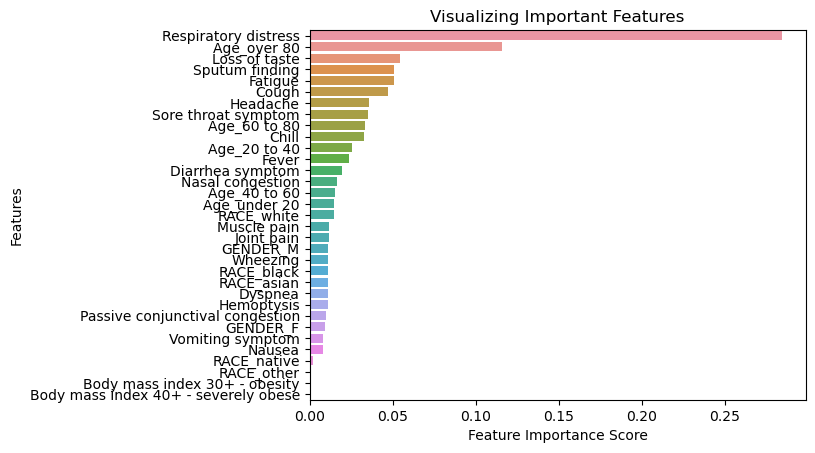

In [241]:
feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## KNN

In [252]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [255]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a KNN classifier with Hamming distance
knn_classifier = KNeighborsClassifier(metric='hamming')

# Train the model
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


# Access the value of k used in the model
k_value = knn_classifier.n_neighbors

print(f"The value of k in the KNN classifier is: {k_value}")

/Users/torinw/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.9589950090744102
The value of k in the KNN classifier is: 5


In [257]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(precision, recall, f1)

0.9500584332784472 0.9589950090744102 0.9527142827695547


In [259]:
# Assuming knn_classifier.predict_proba(X_test)[:, 1] gives the probability of class 1
y_probs = knn_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = auc(fpr, tpr)

print(auc_score)

0.8479644209283576


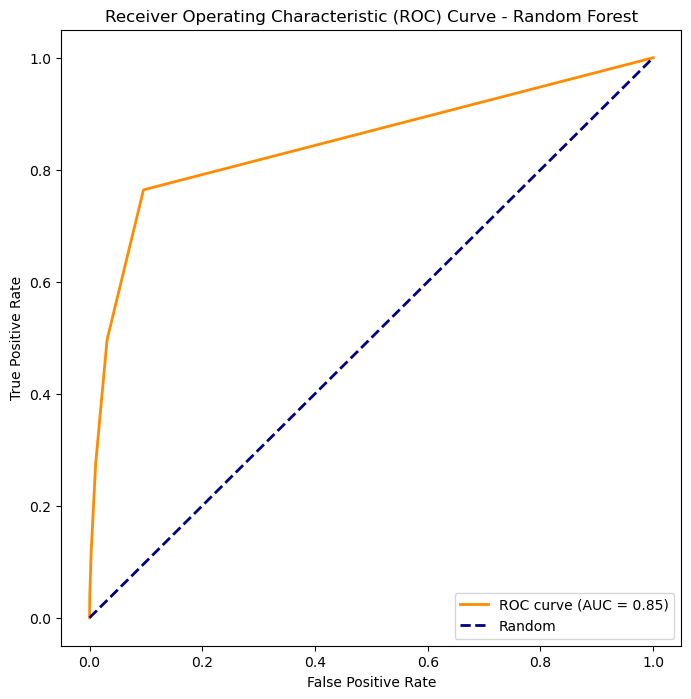

In [262]:
# Compute ROC curve and AUC
y_probs = knn_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc='lower right')
plt.show()

In [260]:
class_report = classification_report(y_test, y_pred)
print("Classification Report\n")
print(class_report)

Classification Report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16886
           1       0.53      0.27      0.36       746

    accuracy                           0.96     17632
   macro avg       0.75      0.63      0.67     17632
weighted avg       0.95      0.96      0.95     17632

